In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/matching_constraints.py')

In [4]:
# Load cell quad strengths from previous notebook
env.vars.load_json('strengths_quads_00_arc_cell.json')

In [5]:
line = env['cell_u']

In [6]:
tt = line.get_table(attr=True)
tt_sext = tt.rows[tt.element_type == 'Sextupole']
tt_sext.show()

name                s element_type isthick isreplica parent_name iscollective        length ...
sf2a::0       32.6591 Sextupole       True     False None               False           0.3
sd1a::0       61.8788 Sextupole       True     False None               False          0.52
sf1a::0       93.3285 Sextupole       True     False None               False           0.3
sd2a::0       125.098 Sextupole       True     False None               False          0.52
sd2a::1       192.581 Sextupole       True     False None               False          0.52
sf1a::1       224.571 Sextupole       True     False None               False           0.3
sd1a::1       255.801 Sextupole       True     False None               False          0.52
sf2a::1        285.24 Sextupole       True     False None               False           0.3


In [7]:
for ss in ['sf1a', 'sf2a', 'sd1a', 'sd2a']:
    print(f'{ss}.k2 = {line[ss].get_expr("k2")}')

sf1a.k2 = vars['ksf1']
sf2a.k2 = vars['ksf2']
sd1a.k2 = vars['ksd1']
sd2a.k2 = vars['ksd2']


In [8]:
env.vars.default_to_zero = True
env['ksf1'] = 'ksffam1'
env['ksf2'] = 'ksffam2'
env['ksd1'] = 'ksdfam1'
env['ksd2'] = 'ksdfam2'
env.vars.default_to_zero = False

In [9]:
# Match chromaticity
opt_chrom = line.match(
    name='linear chromaticity',
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksffam1', 'ksffam2', 'ksdfam1', 'ksdfam2'], step=1e-4),
    targets=xt.TargetSet(dqx=env['dqx_cell'], dqy=env['dqy_cell'], tol=1e-3)
)
opt = opt_chrom
opt.step(20)

                                             
Optimize [linear chromaticity] - start penalty: 1.187
Matching: model call n. 13               
Optimize [linear chromaticity] - end penalty:  1.66439e-06


In [10]:
opt.target_status()

Target status:                           
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    dqx    True   1.66439e-06      0.132169      0.132168 line=cell_u, 'dqx', val=0.132168, tol=0. ...
1  ON    dqy    True   5.23037e-12      0.135034      0.135034 line=cell_u, 'dqy', val=0.135034, tol=0. ...


In [11]:
aux_line = 300*env['cell_u']

In [12]:
tw_aux = aux_line.twiss4d()
tw_aux.qx, tw_aux.qy

(211.87525966547796, 185.2229927983148)

In [13]:
opt_tunes = aux_line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6'], step=1e-5),
    targets=xt.TargetSet(qx=212.2, qy=185.2, tol=1e-5)
)
opt_tunes.step(40)

                                             
Optimize - start penalty: 3.256         
Matching: model call n. 17               
Optimize - end penalty:  1.89551e-07


In [14]:
opt_tunes.target_status()
opt_tunes.vary_status()

Target status:                           
id state tag tol_met       residue   current_val    target_val description                          
0  ON    qx     True   1.43452e-08         212.2         212.2 'qx', val=212.2, tol=1e-05, weight=10
1  ON    qy     True    -1.239e-08         185.2         185.2 'qy', val=185.2, tol=1e-05, weight=10
Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqd1 None           -0.0133482 None           -0.0133447         1e-05             1
1  ON        OK  kqf2 None            0.0111405 None            0.0111273         1e-05             1
2  ON        OK  kqd3 None           -0.0135764 None           -0.0135698         1e-05             1
3  ON        OK  kqf4 None            0.0112145 None             0.011201         1e-05             1
4  ON        OK  kqd5 None           -0.0138718 None           -0.0138652         1e-05             1
5  ON        

In [15]:
import sys
sys.path.append('../002_design_optics/')
from starfish import Starfish

The FCC toolkit includes a `starfish` action that tracks five tursn and measures the rms of the normalize momenta at the fifth turn, whis is expected to be zero in the absence of amplitude detuning.

In [16]:
nemitt_x=1e-7
nemitt_y=1e-8
n_test = 10

from starfish import Starfish
starfish = Starfish(aux_line, nemitt_x=nemitt_x, nemitt_y=nemitt_y, n_test=n_test)

(6.245135657934493, 6.245135657934493, 66.98648420317562)

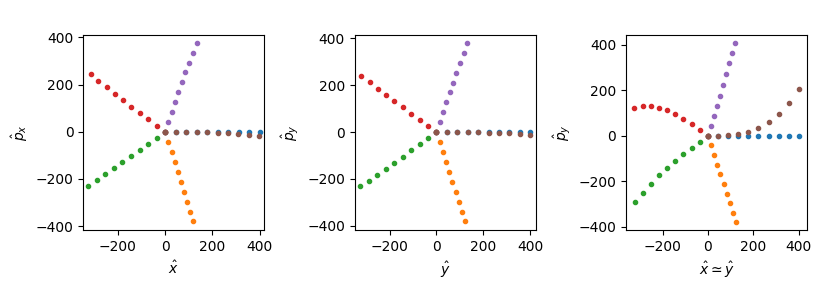

In [17]:
sf = starfish.run(plot=True)
sf['px_norm_rms_5'], sf['px_norm_rms_5'], sf['pxy_norm_rms_5']

In [18]:
opt_starfish = line.match(
    name='starfish',
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksffam1', 'ksffam2', 'ksdfam1', 'ksdfam2'], step=1e-4),
    targets=[xt.TargetSet(dqx=env['dqx_cell'], dqy=env['dqy_cell'], tol=1e-3),
             starfish.target('px_norm_rms_5', 0),
             starfish.target('pxy_norm_rms_5', 0)]
)
opt = opt_starfish
opt.step(10)

                                             
Optimize [starfish] - start penalty: 67.28
Matching: model call n. 79               
Optimize [starfish] - end penalty:  0.0236949


In [19]:
opt.target_status()

Target status:                           
id state tag            tol_met       residue   current_val    target_val description                                 
0  ON    dqx               True   8.14293e-07      0.132168      0.132168 line=cell_u, 'dqx', val=0.132168, tol=0. ...
1  ON    dqy               True    7.8948e-13      0.135034      0.135034 line=cell_u, 'dqy', val=0.135034, tol=0. ...
2  ON    px_norm_rms_5    False    0.00383235    0.00383235             0 'px_norm_rms_5', val=0, tol=1e-09, weigh ...
3  ON    pxy_norm_rms_5   False      0.023383      0.023383             0 'pxy_norm_rms_5', val=0, tol=1e-09, weig ...


(0.0038323535467312676, 0.0038323535467312676, 0.023382956619036582)

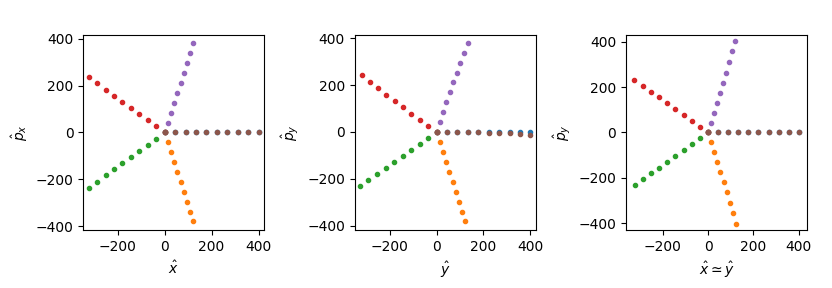

In [20]:
sf = starfish.run(plot=True)
sf['px_norm_rms_5'], sf['px_norm_rms_5'], sf['pxy_norm_rms_5']

### Back to initial tunes

In [21]:
opt_tunes.reload(0)

In [22]:
tw = line.twiss4d()

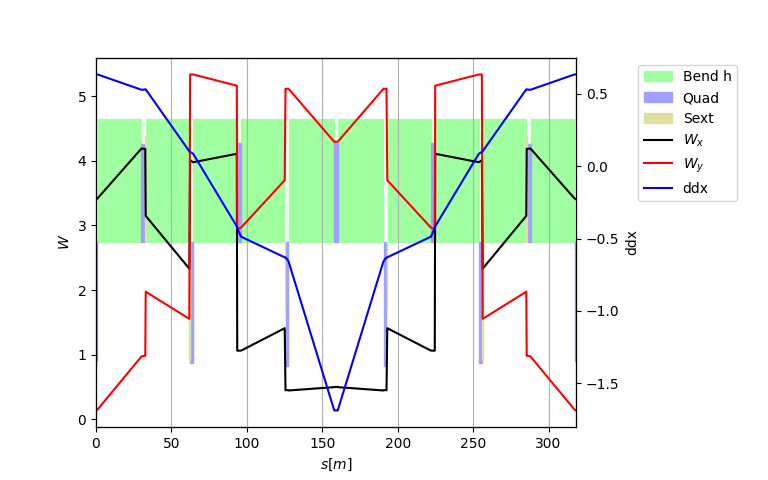

In [23]:
tw.plot(yl='wx_chrom wy_chrom', yr='ddx')

In [24]:
opt_starfish.get_knob_values()

{'ksffam1': 0.28260188391810576,
 'ksffam2': 0.24337297707744918,
 'ksdfam1': -0.27019533179388233,
 'ksdfam2': -0.15607404707497327}

In [25]:
out_ks_vars = ['ksf1', 'ksf2', 'ksd1', 'ksd2',
            'ksffam1', 'ksffam2', 'ksdfam1', 'ksdfam2']
tt_vars = line.vars.get_table()
tt_ks_vars = tt_vars.rows[out_ks_vars]

tt_ks_vars.show()

name            value expr   
ksf1         0.282602 ksffam1
ksf2         0.243373 ksffam2
ksd1        -0.270195 ksdfam1
ksd2        -0.156074 ksdfam2
ksffam1      0.282602 None   
ksffam2      0.243373 None   
ksdfam1     -0.270195 None   
ksdfam2     -0.156074 None   


In [26]:
strengths = tt_ks_vars.to_dict()

In [27]:
strengths

{'ksf1': 'ksffam1',
 'ksf2': 'ksffam2',
 'ksd1': 'ksdfam1',
 'ksd2': 'ksdfam2',
 'ksffam1': 0.28260188391810576,
 'ksffam2': 0.24337297707744918,
 'ksdfam1': -0.27019533179388233,
 'ksdfam2': -0.15607404707497327}

In [28]:
xt.json.dump(strengths, 'strengths_sext_00_arc_cell.json')